# Tuner Prototype

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score, accuracy_score
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from scipy.stats import zscore
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

## Data Processing


In [2]:
digits = load_digits()

cal_housing = fetch_california_housing(as_frame=True)

cleanData = cal_housing.data
cleanData['y'] = cal_housing.target

cleanData = cleanData.drop(columns=['Longitude', 'Latitude'])

for feature in ['AveBedrms', 'AveRooms', 'AveOccup', 'Population']:
    cleanData = cleanData[(np.abs(zscore(cleanData[feature])) < 2.5)]
cleanTarget = cleanData['y'].to_list()

cleanData.drop(columns=['y'], inplace=True)

modelData = cleanData.copy()

## Tuner

In [ ]:
class ModelTuner:
    def __init__(self, models_param_spaces, scoring_criteria):
        self.models_param_spaces = models_param_spaces
        self.scoring_criteria = scoring_criteria
        self.tuned_models = {}

    def tune_model(self, task_type, search_type, model_name, model, param_space, X_train, y_train, X_test, y_test):
        """Tunes the model using the specified search type."""
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('model', model())
        ])
        
        # Initialize search object
        if search_type == 'bayesian':
            search = BayesSearchCV(
                estimator=pipe,
                search_spaces=param_space,
                n_iter=50,
                cv=4,
                scoring=None,  # Will set dynamically
                n_jobs=-1,
                random_state=42
            )
        
        # Loop over scoring metrics
        for scoring_metric in self.scoring_criteria[task_type]:
            print(f"Tuning {model_name} ({task_type}) with {search_type} search and scoring metric: {scoring_metric}")
            search.set_params(scoring=scoring_metric)
            search.fit(X_train, y_train)

            print(f"Best Params: {search.best_params_}")
            print(f"Best Score (Train): {search.best_score_}")
            test_score = search.score(X_test, y_test)
            print(f"Test Score: {test_score}")
            print("-" * 80)

            if task_type == 'regression':
                self.plot_regression_results(search.best_estimator_, X_test, y_test)
            else:
                self.plot_confusion_matrix(search.best_estimator_, X_test, y_test)
        
        # Save the tuned model
        self.tuned_models[model_name] = search

        return search

    def tune_all_models(self, task_type, search_type, X_train, y_train, X_test, y_test):
        # Separate models based on task type
        if task_type == 'classification':
            model_dicts = {k: v for k, v in self.models_param_spaces.items() if 'Classifier' in k}
        elif task_type == 'regression':
            model_dicts = {k: v for k, v in self.models_param_spaces.items() if 'Regressor' in k}
        else:
            raise ValueError(f"Invalid task_type '{task_type}'. Must be 'classification' or 'regression'.")
    
        """ Tune each model using the relevant parameter space"""
        all_metrics = []  # List to collect metrics for all models

        # Tune each model using the relevant parameter space
        for model_name, model_dict in model_dicts.items():
            if search_type in model_dict:
                param_space = model_dict[search_type]
                model = globals()[model_name]

                self.tune_model(task_type, search_type, model_name, model, param_space, X_train, y_train, X_test, y_test)
                
                for scoring_metric in self.scoring_criteria[task_type]:
                    print(f"Evaluating {model_name} with scoring metric: {scoring_metric}")
                    metrics_df = self.evaluate_model(model_name, task_type, scoring_metric, X_test, y_test)
                    all_metrics.append(metrics_df)
                
                all_metrics.append(metrics_df)

        all_metrics_df = pd.concat(all_metrics, ignore_index=True)
        self.plot_all_metrics(all_metrics_df)

        return all_metrics_df

    def evaluate_model(self, model_name, task_type, scoring_metric, X_test, y_test):
        """Evaluate the tuned model, display relevant results, and plot visualizations."""
        search = self.tuned_models.get(model_name)

        metrics_list = []

        if not search:
            raise ValueError(f"Model {model_name} not tuned yet!")

        y_pred = search.best_estimator_.predict(X_test)

        if task_type == 'classification':
            accuracy = accuracy_score(y_test, y_pred)

            report = classification_report(y_test, y_pred, output_dict=True)
            print(f"Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}")
            
            for class_name, metrics in report.items():
                if class_name != 'accuracy':
                    metrics_list.append({
                        'Model': model_name,
                        'Scoring Metric': scoring_metric,
                        'Task': 'Classification',
                        'Class': class_name,
                        'Precision': metrics['precision'],
                        'Recall': metrics['recall'],
                        'F1-Score': metrics['f1-score'],
                        'Support': metrics['support'],
                        'Accuracy': accuracy
                    })

        elif task_type == 'regression':
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            print(f"Evaluation Metrics for {model_name}:\nMean Squared Error: {mse:.4f}\nR² Score: {r2:.4f}")
            
            metrics_list.append({
                'Model': model_name, 
                'Scoring Metric': scoring_metric, 
                'Task': 'Regression', 
                'MSE': mse, 
                'R2': r2, 
                'Accuracy': None
            })

        metrics_df = pd.DataFrame(metrics_list)
        
        # Convert metrics to DataFrame
        return metrics_df

    def plot_confusion_matrix(self, best_estimator, X_test, y_test):
        """Plot confusion matrix for classification."""
        y_pred = best_estimator.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    def plot_regression_results(self, best_estimator, X_test, y_test):
        """Plot regression results."""
        y_pred = best_estimator.predict(X_test)
        plt.scatter(np.array(y_test), y_pred, alpha=0.7, edgecolors='k')
        plt.plot([np.array(y_test).min(), np.array(y_test).max()], [np.array(y_test).min(), np.array(y_test).max()], 'r--', lw=2)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Regression Results")
        plt.show()

    def plot_all_metrics(self, all_metrics_df):
        """Plot metrics for all models based on scoring criteria."""
        plt.figure(figsize=(12, 6))

        # Classification case
        if 'Precision' in all_metrics_df.columns:
            # Filter out rows for classification models
            classification_models = ['DecisionTreeClassifier', 'RandomForestClassifier']
            
            # Filter the dataframe for classification models and macro avg class
            classification_data = all_metrics_df[
                (all_metrics_df['Model'].isin(classification_models)) & 
                (all_metrics_df['Class'] == 'macro avg')
            ]

            # Reshape the dataframe to a long format (melt)
            classification_data = classification_data.melt(
                id_vars=['Model', 'Scoring Metric', 'Class'],
                value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                var_name='variable', 
                value_name='value'
            )

            # Plot all metrics for classification models
            sns.barplot(x='Model', y='value', hue='variable', data=classification_data)
            plt.title("Classification Model Performance Metrics (Macro Average)")
            plt.ylabel('Score')
            plt.xlabel('Model')
            plt.xticks(rotation=45)

        # Regression case
        elif 'R2' in all_metrics_df.columns:
            # Filter out rows for regression models
            regression_models = ['DecisionTreeRegressor', 'RandomForestRegressor']

            # Filter the dataframe for regression models
            regression_data = all_metrics_df[all_metrics_df['Model'].isin(regression_models)]

            # Reshape the dataframe to a long format (melt)
            regression_data = regression_data.melt(
                id_vars=['Model', 'Scoring Metric'],
                value_vars=['R2', 'MSE'],
                var_name='variable', 
                value_name='value'
            )

            # Plot all metrics for regression models
            sns.barplot(x='Model', y='value', hue='variable', data=regression_data)
            plt.title("Regression Model Performance Metrics")
            plt.ylabel('Score')
            plt.xlabel('Model')
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()


## Scoring & Params Definition

In [17]:
# Scoring criteria
scoring_criteria = {
    'classification': ['accuracy'], #, 'f1_macro', 'balanced_accuracy', 'precision_macro', 'recall_macro', 'average_precision'],
    'regression': ['r2', 'neg_mean_squared_error'] # 'neg_mean_absolute_error', 'neg_median_absolute_error', 'max_error', 'explained_variance', 'neg_root_mean_squared_error'
}

# Classifier and regressor parameter spaces
models_param_spaces = {
    'DecisionTreeClassifier': {
        'bayesian': {
            'model__max_depth': Integer(1, 3),
            'pca__n_components': Integer(1, len(digits.data[0])),
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False],
        }
    },
    'RandomForestClassifier': {
        'bayesian': {
            'model__max_depth': Integer(1, 3),
            'pca__n_components': Integer(1, len(digits.data[0])),
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False],
        }
    },
    'DecisionTreeRegressor': {
        'bayesian': {
            'model__max_depth': Integer(2, 3),
            'pca__n_components': Integer(1, len(modelData.columns)),
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False],
        }
    },
    'RandomForestRegressor': {
        'bayesian': {
            'model__max_depth': Integer(2, 3),
            'pca__n_components': Integer(1, len(modelData.columns)),
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False],
        }
    }
}


In [18]:
## Tuning
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(digits.data, digits.target, test_size=0.3, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(modelData, cleanTarget, test_size=0.3, random_state=42)


In [19]:
tuner = ModelTuner(models_param_spaces, scoring_criteria)


### CLF


Tuning DecisionTreeClassifier (classification) with bayesian search and scoring metric: accuracy
Best Params: OrderedDict({'model__max_depth': 3, 'pca__n_components': 14, 'scaler__with_mean': False, 'scaler__with_std': False})
Best Score (Train): 0.4590309372156506
Test Score: 0.45925925925925926
--------------------------------------------------------------------------------


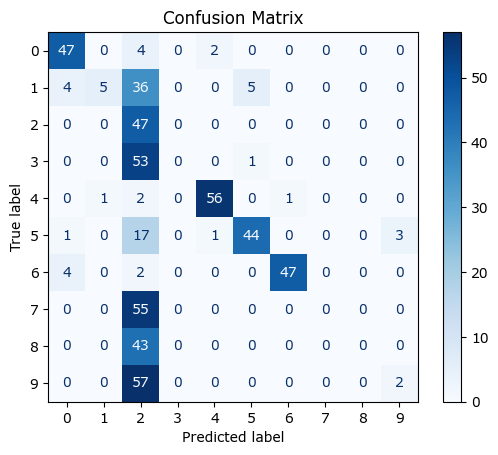

Evaluating DecisionTreeClassifier with scoring metric: accuracy
Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        53
           1       0.83      0.10      0.18        50
           2       0.15      1.00      0.26        47
           3       0.00      0.00      0.00        54
           4       0.95      0.93      0.94        60
           5       0.88      0.67      0.76        66
           6       0.98      0.89      0.93        53
           7       0.00      0.00      0.00        55
           8       0.00      0.00      0.00        43
           9       0.40      0.03      0.06        59

    accuracy                           0.46       540
   macro avg       0.50      0.45      0.40       540
weighted avg       0.53      0.46      0.42       540

Tuning RandomForestClassifier (classification) with bayesian search and scoring metric: accuracy
Best Params: OrderedDict({'mod

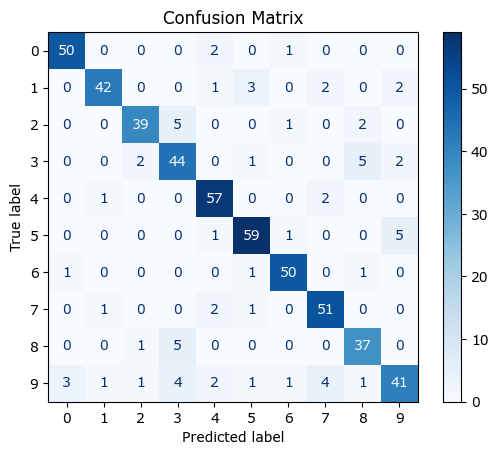

Evaluating RandomForestClassifier with scoring metric: accuracy
Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93        53
           1       0.93      0.84      0.88        50
           2       0.91      0.83      0.87        47
           3       0.76      0.81      0.79        54
           4       0.88      0.95      0.91        60
           5       0.89      0.89      0.89        66
           6       0.93      0.94      0.93        53
           7       0.86      0.93      0.89        55
           8       0.80      0.86      0.83        43
           9       0.82      0.69      0.75        59

    accuracy                           0.87       540
   macro avg       0.87      0.87      0.87       540
weighted avg       0.87      0.87      0.87       540



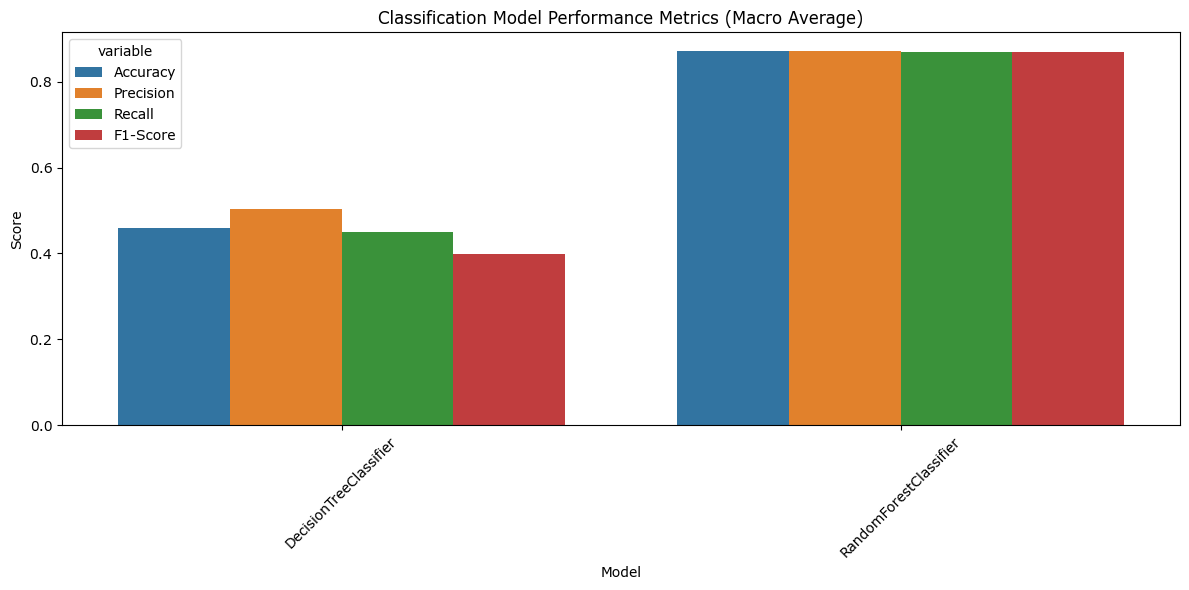

,Model,Scoring Metric,Task,Class,Precision,Recall,F1-Score,Support,Accuracy
0,DecisionTreeClassifier,accuracy,Classification,0,0.839286,0.886792,0.862385,53.0,0.459259
1,DecisionTreeClassifier,accuracy,Classification,1,0.833333,0.100000,0.178571,50.0,0.459259
2,DecisionTreeClassifier,accuracy,Classification,2,0.148734,1.000000,0.258953,47.0,0.459259
3,DecisionTreeClassifier,accuracy,Classification,3,0.000000,0.000000,0.000000,54.0,0.459259
4,DecisionTreeClassifier,accuracy,Classification,4,0.949153,0.933333,0.941176,60.0,0.459259
5,DecisionTreeClassifier,accuracy,Classification,5,0.880000,0.666667,0.758621,66.0,0.459259
6,DecisionTreeClassifier,accuracy,Classification,6,0.979167,0.886792,0.930693,53.0,0.459259
7,DecisionTreeClassifier,accuracy,Classification,7,0.000000,0.000000,0.000000,55.0,0.459259
8,DecisionTreeClassifier,accuracy,Classification,8,0.000000,0.000000,0.000000,43.0,0.459259
9,DecisionTreeClassifier,accuracy,Classification,9,0.400000,0.033898,0.062500,59.0,0.459259


In [7]:
tuner.tune_all_models('classification', 'bayesian', X_train_clf, y_train_clf, X_test_clf, y_test_clf)


### REG


Tuning DecisionTreeRegressor (regression) with bayesian search and scoring metric: r2
Best Params: OrderedDict({'model__max_depth': 3, 'pca__n_components': 5, 'scaler__with_mean': True, 'scaler__with_std': False})
Best Score (Train): 0.5379142717679603
Test Score: 0.5314187114415346
--------------------------------------------------------------------------------


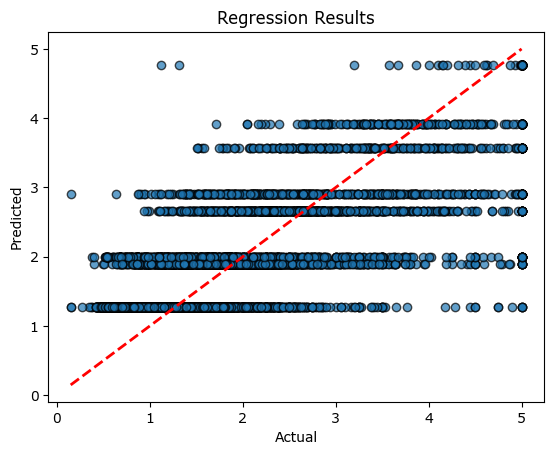

Tuning DecisionTreeRegressor (regression) with bayesian search and scoring metric: neg_mean_squared_error
Best Params: OrderedDict({'model__max_depth': 3, 'pca__n_components': 5, 'scaler__with_mean': True, 'scaler__with_std': False})
Best Score (Train): -0.6016906858268238
Test Score: -0.6164030020791949
--------------------------------------------------------------------------------


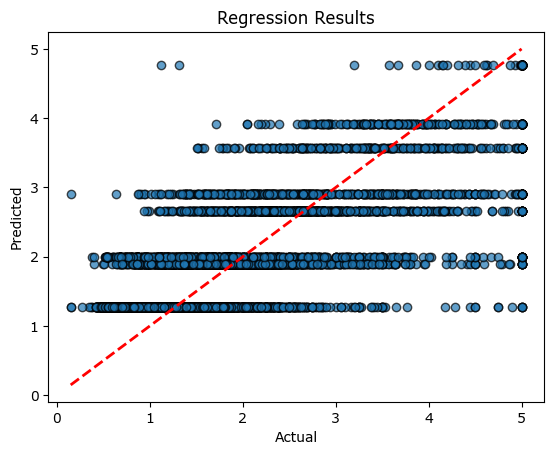

Evaluating DecisionTreeRegressor with scoring metric: r2
Evaluation Metrics for DecisionTreeRegressor:
Mean Squared Error: 0.6164
R² Score: 0.5314
Evaluating DecisionTreeRegressor with scoring metric: neg_mean_squared_error
Evaluation Metrics for DecisionTreeRegressor:
Mean Squared Error: 0.6164
R² Score: 0.5314
Tuning RandomForestRegressor (regression) with bayesian search and scoring metric: r2
Best Params: OrderedDict({'model__max_depth': 3, 'pca__n_components': 5, 'scaler__with_mean': False, 'scaler__with_std': False})
Best Score (Train): 0.5683849634983764
Test Score: 0.5552558757921529
--------------------------------------------------------------------------------


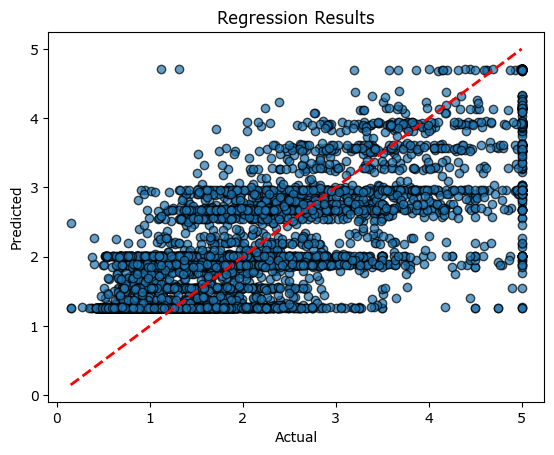

Tuning RandomForestRegressor (regression) with bayesian search and scoring metric: neg_mean_squared_error
Best Params: OrderedDict({'model__max_depth': 3, 'pca__n_components': 5, 'scaler__with_mean': True, 'scaler__with_std': False})
Best Score (Train): -0.5617746263214927
Test Score: -0.5842180029693339
--------------------------------------------------------------------------------


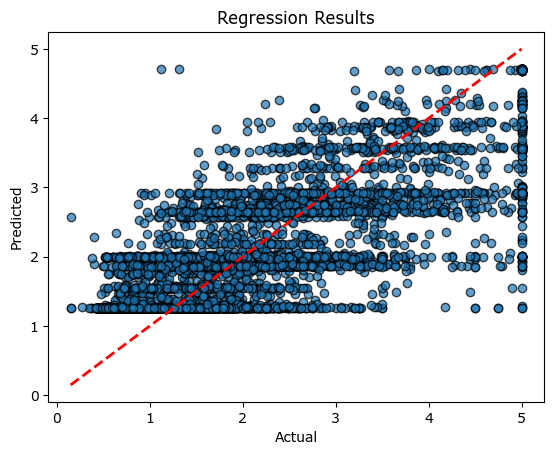

Evaluating RandomForestRegressor with scoring metric: r2
Evaluation Metrics for RandomForestRegressor:
Mean Squared Error: 0.5842
R² Score: 0.5559
Evaluating RandomForestRegressor with scoring metric: neg_mean_squared_error
Evaluation Metrics for RandomForestRegressor:
Mean Squared Error: 0.5842
R² Score: 0.5559


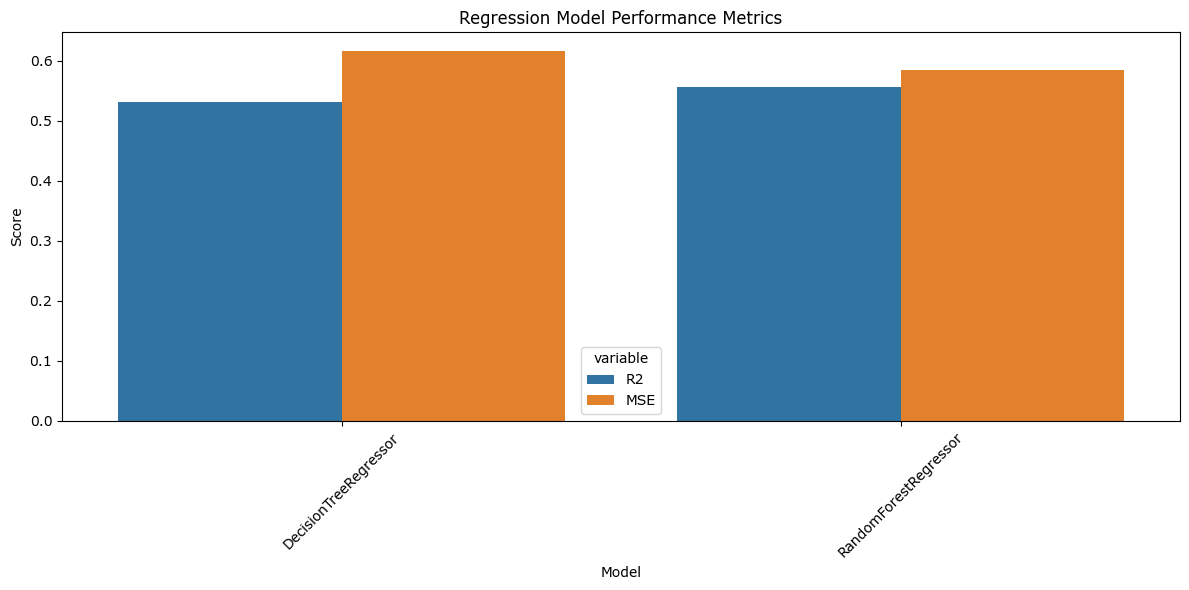

,Model,Scoring Metric,Task,MSE,R2,Accuracy
0,DecisionTreeRegressor,r2,Regression,0.616403,0.531419,None
1,DecisionTreeRegressor,neg_mean_squared_error,Regression,0.616403,0.531419,None
2,DecisionTreeRegressor,neg_mean_squared_error,Regression,0.616403,0.531419,None
3,RandomForestRegressor,r2,Regression,0.584218,0.555885,None
4,RandomForestRegressor,neg_mean_squared_error,Regression,0.584218,0.555885,None
5,RandomForestRegressor,neg_mean_squared_error,Regression,0.584218,0.555885,None


In [20]:
tuner.tune_all_models('regression', 'bayesian', X_train_reg, y_train_reg, X_test_reg, y_test_reg)
